In [1]:

%matplotlib inline
%load_ext autoreload

%autoreload 2
import os
import sys
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from dnc.dnc import DNC
import dnc.utility as uf

# from feedforward_controller import FeedforwardController
from basic_recurrent_controller import BasicRecurrentController
from focus_recurrent_controller import FocusRecurrentController

from tqdm import tqdm
import time
import seaborn as sns
plt.rcParams['figure.figsize'] = (5, 10)

sess = None
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data', one_hot=True)

# TODO: For the DNC-controlled sliding window, just make the "sequence input" to the DNC be a sequence of images. Then
# make the first step of the controller to be to apply the index window on top of the image

In [ ]:
# num_labels = 2
def make_ims():
    size = 8
#     _, Input, Target_Output = uf.get_lrb_images(bsize, size=im_size, splits=im_splits)
#     Input, _, Target_Output = uf.get_center_bar_images(bsize, size=8, splits=4, stagger=False)
    Input, _, Target_Output = uf.get_right_bar_images(bsize, size=8, splits=4, stagger=False)
    return Input, Target_Output


if not sess is None:
    sess.close()

bsize = 1
input_size = 64
num_labels = 2
sequence_length = 16
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))

ncomputer = DNC(
    FocusRecurrentController,
    input_size=input_size,
    output_size=num_labels,
    max_sequence_length=sequence_length,
    memory_words_num=10,
    memory_word_size=10,
    memory_read_heads=1,
    batch_size=bsize
)
assert ncomputer.controller.has_recurrent_nn

raw_outputs, memory_views = ncomputer.get_outputs()
output = tf.argmax(raw_outputs[:, sequence_length - 1, :], 1)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(raw_outputs[:, sequence_length - 1, :], 
                                                              ncomputer.target_output_final))

start = time.time()
updt = uf.get_updt(loss)
print time.time() - start

init = tf.global_variables_initializer()
print "initializing..."
sess.run(init)
print "initialized!"



 25%|██▌       | 4/16 [00:04<00:13,  1.15s/it]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


100%|██████████| 16/16 [00:16<00:00,  1.07s/it]


computing gradients...


  0%|          | 0/19 [00:00<?, ?it/s]100%|██████████| 19/19 [00:00<00:00, 255.96it/s]


applying gradients...
45.3929309845
initializing...
initialized!


In [ ]:
#TODO: Add focus inds to outputs for easier visualization


print_step = 200
losses = []
inputs = []
outputs = []
targets = []
views = []
focuses = []

for i in tqdm(range(1000000)):
    
    Input, Target_Output = make_ims()

    OUT = sess.run([
        loss,
        output,
        memory_views,
        updt] + 
        ncomputer.controller.focus_row +
        ncomputer.controller.focus_col
        , feed_dict={
        ncomputer.input_data: Input,
        ncomputer.target_output_final: Target_Output,
        ncomputer.sequence_length: sequence_length
    })
    l, o, v = OUT[:3]
    fr = OUT[4:4+len(ncomputer.controller.focus_row)]
    fc = OUT[4+len(ncomputer.controller.focus_row):]
    pairs = zip(np.argmax(np.array(fr)[:,0,:], -1), np.argmax(np.array(fc)[:,0,:], -1))

    losses.append(l)
    inputs.append(Input)
    outputs += list(o)
    views.append(v)
    targets += list(np.argmax(Target_Output, axis=-1))
    focuses.append(pairs)
    if len(targets) % print_step == 0 and len(targets) > 0:
        print "loss", np.mean(losses[-print_step:])
        print "matches", np.mean(np.array(targets[-print_step:]) == np.array(outputs[-print_step:]))


  0%|          | 0/1000000 [00:00<?, ?it/s]dnc/utility.py:166: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  label[pos] = 1
  0%|          | 201/1000000 [01:00<60:41:56,  4.58it/s] 

loss 0.693148
matches 0.45


  0%|          | 267/1000000 [01:18<77:12:11,  3.60it/s]  0%|          | 203/1000000 [01:01<58:38:41,  4.74it/s]

In [18]:
focuses[-9]

[(3, 1),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2)]

In [ ]:
ix = 4
v = views[ix]
print targets[ix]
Input = inputs[ix]

for i, w, r in zip(range(4), np.squeeze(v['write_weightings'][0]), np.squeeze(v['read_weightings'][0])):
    plt.subplot(2,2,i + 1)
    plt.plot(w, label="w")
    plt.plot(r, label="r")
    plt.legend()

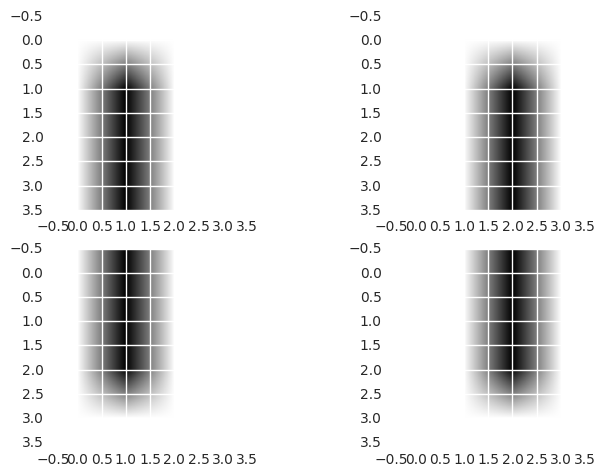

In [61]:
plt.subplot(2,2,1)
plt.imshow(np.reshape(Input[0][0], (4,4)))
plt.subplot(2,2,2)
plt.imshow(np.reshape(Input[0][1], (4,4)))
plt.subplot(2,2,3)
plt.imshow(np.reshape(Input[0][2], (4,4)))
plt.subplot(2,2,4)
plt.imshow(np.reshape(Input[0][3], (4,4)))

In [20]:
# # batch_x, batch_y = mnist.train.next_batch(bsize)
# # Input, Target_Output = get_im_sequence(batch_x, batch_y)
# Input, _, Target_Output = make_ims(bsize, size=im_size, splits=im_splits)

# l, o, v, _ = sess.run([
#     loss,
#     output,
#     memory_views, 
#     updt
# ], feed_dict={
#     ncomputer.input_data: Input,
#     ncomputer.target_output_final: Target_Output,
#     ncomputer.sequence_length: sequence_length
# })
# o

array([1])

In [6]:
# ncomputer.save(sess, "ckpts", "basic_recurrent_controller_get_lrb_images_task.ckpt")

In [ ]:

#TODO: VISUALIZE GRADIENTS AND MEMORY

















In [34]:
# print Target_Output
# plt.subplot(2,2,1)
# plt.imshow(np.reshape(Input[0][0], (4,4)))
# plt.subplot(2,2,2)
# plt.imshow(np.reshape(Input[0][1], (4,4)))
# plt.subplot(2,2,3)
# plt.imshow(np.reshape(Input[0][2], (4,4)))
# plt.subplot(2,2,4)
# plt.imshow(np.reshape(Input[0][3], (4,4)))